In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import string
# model
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

import sklearn.metrics as metrics

In [3]:
train_data = pd.read_csv('train_data3.csv')
train_data.head()

,index,id,content,title,preprocessed_content,label,hierarchy,hierarchy_#tiers,tier1,tier2,tier3,tier4
0,133,https://www.whowhatwear.com/5-looks-that-put-b...,After seeing burgundy boots on some of our fav...,5 Looks That Put Burgundy Boots On Our Must-Ha...,seeing burgundy boot favorite street style blo...,Womens\ Casual\ Wear,"[{'Style & Fashion': {""Women's Fashion"": {""Wom...",4,Style & Fashion,Womens Fashion,Womens Clothing,Womens Casual Wear
1,189,https://www.wisebread.com/what-you-need-to-kno...,"According to a September 29, 2009 Fidelity Inv...",How to Make the Most of Your 401K,according september fidelity investments study...,Personal\ Investing,[{'Personal Finance': 'Personal Investing'}],2,Personal Finance,Personal Investing,NaN,NaN
2,401,https://www.theturekclinic.com/blog/mindful-ea...,"“Thou shouldst eat to live; not live to eat,” ...",Mindful Eating,thou shouldst eat live live eat said socrates ...,Mens\ Health,"[{'Healthy Living': ""Men's Health""}]",2,Healthy Living,Mens Health,NaN,NaN
3,198,https://www.news-medical.net/news/20190611/Ear...,Researchers continue to dig for molecular clue...,Early life adversity and high levels of FKBP5 ...,researchers continue dig molecular clue better...,Hormonal\ Disorders,[{'Medical Health': {'Diseases and Conditions'...,4,Medical Health,Diseases and Conditions,Endocrine and Metabolic Diseases,Hormonal Disorders
4,24,https://hobbylark.com/card-games/Top-Strongest...,"As any duelist knows, the vast majority of Yu-...",Top 10 Strongest (Highest ATK) Monsters in Yu-...,duelist know vast majority yu gi oh match end ...,Card\ Games,[{'Hobbies & Interests': {'Games and Puzzles':...,3,Hobbies & Interests,Games and Puzzles,Card Games,NaN


## Preparation and Pre-processing


In [4]:
lemma = WordNetLemmatizer()
def clean_text(text):
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = " ".join([lemma.lemmatize(word) for word in tokens if word not in set(stopwords.words("english"))])
    return text
def cut_text(text):
    tokens = re.split('\W+', text)
    if len(tokens) > 400:
        tokens = tokens[:200]+tokens[-200:]
    else:
        tokens = tokens
    text = " ".join(tokens)
    return (text)
def combine_text(text1, text2, n):
    text = " ".join([text1]*n)
    text = text + " " + text2
    return text
def concatlabel(tier1, tier2, tier3, tier4):
    try:
        new_label = tier1+'..'+tier2+'..'+tier3+'..'+tier4
    except TypeError:
        try:
            new_label = tier1+'..'+tier2+'..'+tier3
        except TypeError:
            try:
                new_label = tier1+'..'+tier2
            except TypeError:
                new_label = tier1
    return new_label

In [5]:
train_data['label_id'] = train_data['label'].factorize()[0]
train_data['pub'] = train_data['id'].apply(lambda x:"/".join(x.split("/")[:3]))
train_data.dropna(subset = ["preprocessed_content","title"], inplace=True)
train_data['preprocessed_title'] = train_data['title'].apply(clean_text)
train_data['preprocessed_content'] = train_data['preprocessed_content'].apply(cut_text)
train_data['text'] = np.vectorize(combine_text)(train_data['preprocessed_title'], train_data['preprocessed_content'], 30)


In [6]:
col_pick = ['label_id', 'hierarchy_#tiers', 'tier1', 'tier2', 'tier3', 'tier4', 'pub', 'text']
train_data = train_data[col_pick]

In [1]:
train_data['index'] = range(0, len(train_data) )
train_data['label']= ""
for i in (range(len(train_data))):
    train_data['label'].iloc[i]=concatlabel(train_data['tier1'].iloc[i],train_data['tier2'].iloc[i],
            train_data['tier3'].iloc[i],train_data['tier4'].iloc[i])
train_data.head()

NameError: name 'train_data' is not defined

In [8]:
train_data['tier1'], label_1 = pd.factorize(train_data['tier1'])
train_data['tier2'], label_2 = pd.factorize(train_data['tier2'])
train_data['tier3'], label_3 = pd.factorize(train_data['tier3'])
train_data['tier4'], label_4 = pd.factorize(train_data['tier4'])
train_data['label1'] = train_data[train_data.columns[2:6]].apply(
    lambda x: '..'.join(x.astype(str)),
    axis=1
)
train_data['label1'] = train_data['label1'].apply(lambda x: '..'.join([x for x in x.split('..') if x != '-1']))
train_data.head()

,label_id,hierarchy_#tiers,tier1,tier2,tier3,tier4,pub,text,index,label,label1
0,0,4,0,0,0,0,https://www.whowhatwear.com,5 look put burgundy boot musthave list 5 look ...,0,Style & Fashion..Womens Fashion..Womens Clothi...,0..0..0..0
1,1,2,1,1,-1,-1,https://www.wisebread.com,make 401k make 401k make 401k make 401k make 4...,1,Personal Finance..Personal Investing,1..1
2,2,2,2,2,-1,-1,https://www.theturekclinic.com,mindful eating mindful eating mindful eating m...,2,Healthy Living..Mens Health,2..2
3,3,4,3,3,1,1,https://www.news-medical.net,early life adversity high level fkbp5 protein ...,3,Medical Health..Diseases and Conditions..Endoc...,3..3..1..1
4,4,3,4,4,2,-1,https://hobbylark.com,top 10 strongest highest atk monster yugioh to...,4,Hobbies & Interests..Games and Puzzles..Card G...,4..4..2


In [9]:
train_data1 = train_data.drop(['tier3', 'tier4'], axis = 1)
train_data2 = train_data.drop(['tier4'], axis = 1)
train_data1 = train_data1[train_data1['tier2']!= -1]
train_data2 = train_data2[train_data2['tier3']!= -1]
train_data3 = train_data[train_data['tier4']!= -1]
train_data,train_data1,train_data2,train_data3 = train_data.reset_index(drop=True),train_data1.reset_index(drop=True),train_data2.reset_index(drop=True),train_data3.reset_index(drop=True)

## Feature extraction

In [10]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2), stop_words='english')
tfidf_features = tfidf.fit_transform(train_data['text']).toarray()
tfidf_features = pd.DataFrame(tfidf_features)
tfidf_features.columns = tfidf.get_feature_names()
tfidf_features.shape

(8774, 55732)

In [12]:
X_features = tfidf_features

In [14]:
X_features1 = X_features[X_features.index.isin(list(train_data1['index']))]
X_features2 = X_features[X_features.index.isin(list(train_data2['index']))]
X_features3 = X_features[X_features.index.isin(list(train_data3['index']))]

In [15]:
y = train_data[['label_id','hierarchy_#tiers','tier1','tier2','tier3','tier4','label1', 'label']]
y1 = train_data1[['label_id','hierarchy_#tiers','tier1','tier2']]
y2 = train_data2[['label_id','hierarchy_#tiers','tier1','tier2','tier3']]
y3 = train_data3[['label_id','hierarchy_#tiers','tier1','tier2','tier3','tier4']]

n_train = round(X_features.shape[0]*0.7)
n_train1 = round(X_features1.shape[0]*0.7)
n_train2 = round(X_features2.shape[0]*0.7)
n_train3 = round(X_features3.shape[0]*0.7)

X_train, X_test = X_features[:n_train], X_features[n_train:]
X_train1, X_test1 = X_features1[:n_train1], X_features1[n_train1:]
X_train2, X_test2 = X_features2[:n_train2], X_features2[n_train2:]
X_train3, X_test3 = X_features3[:n_train3], X_features3[n_train3:]


y_train, y_test = y[:n_train], y[n_train:]
y_train1, y_test1 = y1[:n_train1], y1[n_train1:]
y_train2, y_test2 = y2[:n_train2], y2[n_train2:]
y_train3, y_test3 = y3[:n_train3], y3[n_train3:]

In [16]:
content_train, content_test = tfidf_features[:n_train], tfidf_features[n_train:]

([], <a list of 0 Text xticklabel objects>)

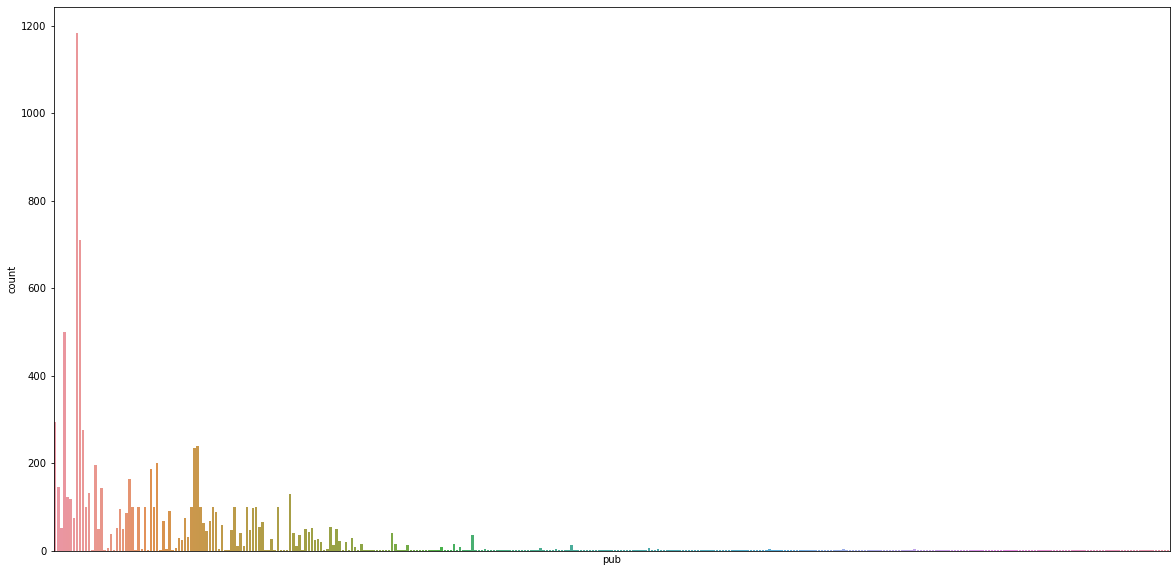

In [43]:
plt.figure(figsize=(20,10))
ax = sns.countplot(x="pub", data=train_data)
plt.xticks([])

## Hierarchical Classification

### Local classifier for each tier

In [17]:
#tier 1 prediction result
model =LinearSVC()
model = CalibratedClassifierCV(model) 
model.fit(X_train, y_train['tier1'])
y_pred = model.predict(X_test)

print("Accuracy",metrics.accuracy_score(y_test['tier1'], y_pred))
print("Precision",metrics.precision_score(y_test['tier1'], y_pred,average='weighted'))
print("Recall",metrics.recall_score(y_test['tier1'], y_pred,average='weighted'))
print("F1-score",metrics.f1_score(y_test['tier1'], y_pred,average='weighted'))

Accuracy 0.9167933130699089
Precision 0.9169555047555801
Recall 0.9167933130699089
F1-score 0.9160996930200291


In [18]:
pred1 = pd.DataFrame(model.predict_proba(X_train1))
pred2 = pd.DataFrame(model.predict_proba(X_train2))
pred3 = pd.DataFrame(model.predict_proba(X_train3))

feature1 = pd.concat([X_train1.reset_index(drop=True), pred1], axis=1)
feature2 = pd.concat([X_train2.reset_index(drop=True), pred2], axis=1)
feature3 = pd.concat([X_train3.reset_index(drop=True), pred3], axis=1)

pred1_test = pd.DataFrame(model.predict_proba(X_test1))
pred2_test = pd.DataFrame(model.predict_proba(X_test2))
pred3_test = pd.DataFrame(model.predict_proba(X_test3))

feature1_test = pd.concat([X_test1.reset_index(drop=True), pred1_test], axis=1)
feature2_test = pd.concat([X_test2.reset_index(drop=True), pred2_test], axis=1)
feature3_test = pd.concat([X_test3.reset_index(drop=True), pred3_test], axis=1)

In [19]:
#tier 2 prediction result, adding tier 1 output

model1 =LinearSVC()
model1 = CalibratedClassifierCV(model1) 
model1.fit(feature1, y_train1['tier2'])
y_pred = model1.predict(feature1_test)

print("Accuracy",metrics.accuracy_score(y_test1['tier2'], y_pred))
print("Precision",metrics.precision_score(y_test1['tier2'], y_pred,average='weighted'))
print("Recall",metrics.recall_score(y_test1['tier2'], y_pred,average='weighted'))
print("F1-score",metrics.f1_score(y_test1['tier2'], y_pred,average='weighted'))

Accuracy 0.8850118953211736
Precision 0.8868359487214247
Recall 0.8850118953211736
F1-score 0.8838241225266444


In [20]:
pred22 = pd.DataFrame(model1.predict_proba(feature2))
feature22 = pd.concat([X_train2.reset_index(drop=True), pred22], axis=1)
pred22_test = pd.DataFrame(model1.predict_proba(feature2_test))
feature22_test = pd.concat([X_test2.reset_index(drop=True), pred22_test], axis=1)

In [21]:
pred33 = pd.DataFrame(model1.predict_proba(feature3))
feature33 = pd.concat([X_train3.reset_index(drop=True), pred33], axis=1)
pred33_test = pd.DataFrame(model1.predict_proba(feature3_test))
feature33_test = pd.concat([X_test3.reset_index(drop=True), pred33_test], axis=1)

In [22]:
#tier 3 prediction result, adding tier 2 output

model2 =LinearSVC()
model2 = CalibratedClassifierCV(model2) 
model2.fit(feature22, y_train2['tier3'])
y_pred = model2.predict(feature22_test)

print("Accuracy",metrics.accuracy_score(y_test2['tier3'], y_pred))
print("Precision",metrics.precision_score(y_test2['tier3'], y_pred,average='weighted'))
print("Recall",metrics.recall_score(y_test2['tier3'], y_pred,average='weighted'))
print("F1-score",metrics.f1_score(y_test2['tier3'], y_pred,average='weighted'))

Accuracy 0.8821520068317678
Precision 0.8885063120656559
Recall 0.8821520068317678
F1-score 0.8799267346571759


In [23]:
pred333 = pd.DataFrame(model2.predict_proba(feature33))
feature333 = pd.concat([X_train3.reset_index(drop=True), pred333], axis=1)
pred333_test = pd.DataFrame(model2.predict_proba(feature33_test))
feature333_test = pd.concat([X_test3.reset_index(drop=True), pred333_test], axis=1)

In [24]:
#tier 4 prediction result, adding tier 3 output

model3 =LinearSVC()
model3 = CalibratedClassifierCV(model3) 
model3.fit(feature333, y_train3['tier4'])
y_pred = model3.predict(feature333_test)
print("Accuracy",metrics.accuracy_score(y_test3['tier4'], y_pred))
print("Precision",metrics.precision_score(y_test3['tier4'], y_pred,average='weighted'))
print("Recall",metrics.recall_score(y_test3['tier4'], y_pred,average='weighted'))
print("F1-score",metrics.f1_score(y_test3['tier4'], y_pred,average='weighted'))

Accuracy 0.8934010152284264
Precision 0.9020543868016665
Recall 0.8934010152284264
F1-score 0.8943091882262068


NameError: name 'pred1' is not defined

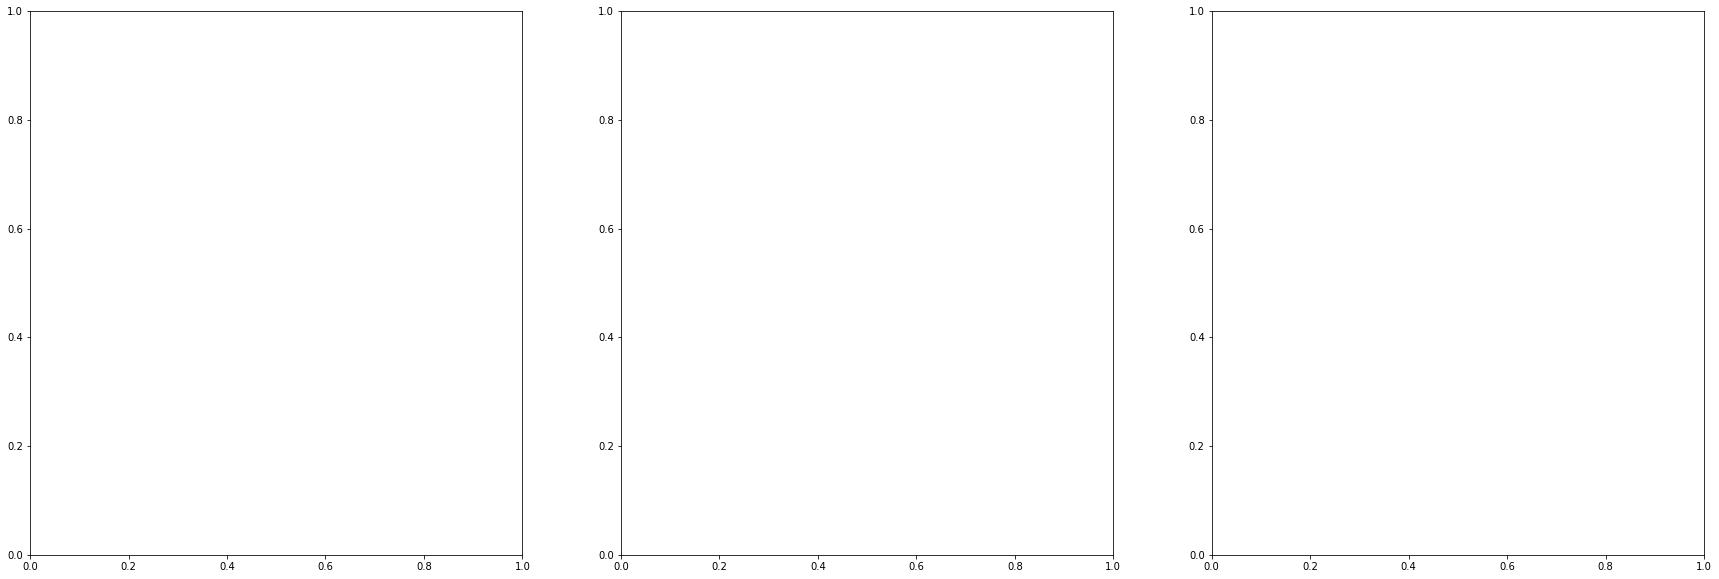

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
f, axes = plt.subplots(1, 3, figsize=(30, 10), sharex=True)
sns.distplot(pred1.max(axis=1), hist=True, kde=True, 
             bins=50, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2}, ax=axes[0]).set_title('tier1')
sns.distplot(pred22.max(axis=1), hist=True, kde=True, 
             bins=50, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},ax=axes[1]).set_title('tier2')
sns.distplot(pred333.max(axis=1), hist=True, kde=True, 
             bins=50, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 2},ax=axes[2]).set_title('tier3')

### #tiers prediction

In [26]:
#predict number of tiers, using content related features
model00 =LinearSVC()
model00 = CalibratedClassifierCV(model00) 
model00.fit(content_train, y_train['hierarchy_#tiers'])
y_pred = model00.predict(content_test)

print("Accuracy",metrics.accuracy_score(y_test['hierarchy_#tiers'], y_pred))
print("Precision",metrics.precision_score(y_test['hierarchy_#tiers'], y_pred,average='weighted'))
print("Recall",metrics.recall_score(y_test['hierarchy_#tiers'], y_pred,average='weighted'))
print("F1-score",metrics.f1_score(y_test['hierarchy_#tiers'], y_pred,average='weighted'))

Accuracy 0.8936170212765957
Precision 0.8927068601516446
Recall 0.8936170212765957
F1-score 0.8916547638007505


## Define hc function

In [3]:
def hc(test):
    p1 = pd.DataFrame(model.predict_proba(test)).set_index(test.index)
    f1 = pd.concat([test, p1], axis=1)
    p2 = pd.DataFrame(model1.predict_proba(f1)).set_index(test.index)
    f2 = pd.concat([test, p2], axis=1)
    p3 = pd.DataFrame(model2.predict_proba(f2)).set_index(test.index)
    f3 = pd.concat([test, p3], axis=1)
    p4 = pd.DataFrame(model3.predict_proba(f3)).set_index(test.index)
    df = pd.DataFrame(model00.predict(test)).set_index(test.index)
    df['tier1'],df['tier2'],df['tier3'],df['tier4'] = model.predict(test),model1.predict(f1),model2.predict(f2),model3.predict(f3)
    df['label1'],df['label2'],df['label3'],df['label4'] = label_1[df['tier1']], label_2[df['tier2']], label_3[df['tier3']], label_4[df['tier4']]
    df['label']=''
    df['label_name']=''
    for i in range(0, df.shape[0]):
        df['label'].iloc[i] = '..'.join(df[df.columns[1:1+df[0].iloc[i]]].iloc[i].astype(str))
        df['label_name'].iloc[i] = '..'.join(df[df.columns[5:5+df[0].iloc[i]]].iloc[i].astype(str))
    return df['label'], df['label_name']
pred, pred_name = hc(X_test)


NameError: name 'X_test' is not defined

In [42]:
print("Accuracy",metrics.accuracy_score(y_test['label1'], pred))

Accuracy 0.800531914893617


In [30]:
misclassified = pd.concat([pd.DataFrame(y_test['label'][y_test['label1'] != pred]), pd.DataFrame(pred_name[y_test['label1'] != pred])], axis = 1)
misclassified.head(30)

,label,label_name
6146,Movies..Family and Children Movies,Movies..Comedy Movies
6148,Style & Fashion..Womens Fashion..Womens Access...,Style & Fashion..Womens Fashion..Womens Access...
6160,Real Estate..Hotel Properties,Events and Attractions..Amusement and Theme Parks
6161,Food & Drink,Books and Literature..Art and Photography Books
6168,News and Politics..Disasters,Science..Geography
6181,Education..Educational Assessment..Standardize...,Education..Homework and Study
6192,Movies..Romance Movies,Movies..Family and Children Movies
6205,Healthy Living..Womens Health,Medical Health..Diseases and Conditions
6212,Pop Culture..Celebrity Deaths,Pop Culture..Celebrity Pregnancy
6217,Events and Attractions..Amusement and Theme Parks,Travel


## Test new articles

In [36]:
test_new = pd.DataFrame(columns = ['website' , 'title', 'content'])
test_new = test_new.append({'website' : 'https://www.forbes.com/sites/jumio/2020/08/03/how-selfie-based-technology-can-create-trust-and-security-for-online-dating-platforms/#2eded4af4e0d' , 
                            'title' : 'How Selfie-Based Technology Can Create Trust And Security For Online Dating Platforms',
                            'content':
                           'When Facebook launched its dating platform in 2019 it faced criticism based on its somewhat controversial use of user data in the past. Amidst this murky background, one of the bigger areas that Facebook Dating, and other online dating sites, should be addressing seriously is how they can create an ecosystem of trust. By doing so, they will make their online dating communities safer. This is particularly important due to catfishing, which is rife amongst dating sites. Catfishing is a scam whereby someone creates a fictitious online identity, often using someone else’s pictures and false biographical information. While MTV made a popular prime-time TV show uncovering this kind of deception in a more light-hearted manner, it can actually become a far darker cause for concern. In the U.S., consumers reported losing $201 million to romance scams in 2019 — up nearly 40% since 2018. But this type of fraud can also have a significant impact on victims health and well-being. So how can online dating sites and apps make the environment a safer place so users feel comfortable putting their hearts — and personal information — on the line? Something old, something new… Trust has to be at the epicenter of any dating site, and this starts the second a new account is created online and that account is verified. Sadly, when dating sites say they verify users, they rely on self-attested information, such as your name, age, city and who you are interested in meeting. This is simply not verification. New users can provide virtually any information they want as there is no fact checking behind any of these online profiles. This is where online dating platforms need to step up and employ verification methods, and ideally, newer methods that are far more secure, deliver much higher levels of identity assurance and help create an environment of trust. The strongest way of doing this is through online identity verification when new accounts are created and face-based authentication for higher-risk activities. The look of love. It is absolutely vital for dating sites to verify information provided by a user. This means that customers will trust the person they are talking to online, safe in the knowledge that their account has been verified, and is not a bot. They will also know that the dating site actually knows the real-world identity of the user should a date take the wrong turn. This creates a whole ecosystem of trust and safety that runs from initially talking to a person online, right through to real-world interactions. Dating sites could even look to verify the actual picture of a customer, to minimize the risk of misleading users with false information about their physical features. Providers of innovative identity proofing and authentication are bringing about a step change for businesses, online dating sites included. Using cutting-edge AI and video-selfie technology, the real-world identity of a user setting up an online account can now reliably be proven. When opening an account, the user will be asked to take a picture of a government-issued ID (e.g., a passport or driver’s licence) using their smartphone or webcam — this creates a reliable trust anchor and checks the ID for fraud. Then, the user will be asked to take a corroborating selfie which includes a built-in liveness check to ensure the person is physically present (and not using a picture or pre-recorded video for their selfie). It’s at this step that a digital representation of the person’s face is created, a 3D face map that can be kept on file for downstream authentication events. This provides a significantly higher bar and helps ensure that the user is truly who they claim to be. If the selfie does not match the picture on the ID, the profile will be flagged as fraudulent. Dating sites could also use the selfie to prove that the user accessing the account is still the person who set it up in higher-risk examples. Let’s say a user wants to verify the real identity of the person they’re about to meet for a date. In this unique scenario, that person would be prompted to take another quick video-selfie, which would create a fresh 3D face map that could then be immediately compared to the original 3D face map created when the account was opened. If the face maps match, the user knows the person they’re about to meet for a date is the genuine article.  Of course, putting your heart on the line is never a risk-free proposition. But, by leveraging the power of face-based biometric verification and authentication solutions, online daters don’t need the additional worry of scammers taking advantage of them. Online dating sites and apps, including Facebook Dating, need to take a deeper interest in the trust and safety of their users if they want to cultivate safer ecosystems. Face-based biometrics and the online dating world is clearly a match made in heaven. '
                           },ignore_index = True)  
test_new = test_new.append({'website' : 'https://www.travelandleisure.com/food-drink/restaurants/oldest-restaurants-in-the-world' , 
                            'title' : 'The 10 Oldest Restaurants in the World Are Way Older Than You May Think',
                            'content': 
                           'The oldest restaurant in the world has served both Mozart and Clint Eastwood. Every year there is some new food trend that seems to sweep the internet. Remember when cupcakes were all the rage? Rainbow grilled cheeses? How about the cronut? But some meals are bigger than trends. And most of those long-lasting dishes can be found in a few of the oldest restaurants in the world. In a time when restaurants seem to come and go with the seasons, there are a few standout stars that have somehow stood the test of time. And we are not talking a few decades — we’re talking a few centuries. NetCredit, a financial services provider, waded into the historical waters and created a list of the oldest restaurants in more than 115 countries around the globe. To reach its conclusion, it simply used the qualification that a restaurant is “still serving today,” meaning it could have changed hands, names, or gone through renovations since its opening day. It then looked through records and historical data to formalize its list of the 10 oldest restaurants in the world. Coming in at the number 10 spot is Gostilna Gastuž, a restaurant that has been serving food in Slovenia since 1467. According to NetCredit, it is long been famous for mushroom soup and buckwheat porridge. Honke Owariya in Japan landed at number nine on the list. It is been doling out its famous soba made with mushrooms, egg, shrimp tempura, nori, leeks, and daikon since 1465. The eighth-oldest restaurant on the list is Hotel Gasthof Löwen, located in Liechtenstein. It’s served happy patrons veal with vegetables since 1380. It’s closely followed by the seventh-oldest restaurant, The Sheep Heid Inn in Scotland, which has served steak and roasted mushrooms since 1360. In 1345, the sixth-oldest restaurant, La Couronne in France, opened its doors to offer duck, roasts, and escargot. And in 1198, the fifth-oldest restaurant, The Brazen Head in Ireland, opened to serve bangers and mash. In the fourth-oldest spot sits Ma Yu Ching’s Bucket Chicken House in China, which first served buckets of chicken in 1153. Just a few years earlier, in 1147, the third-oldest restaurant, The Old House in Wales, began feeding customers pies with chips and peas. And, in 1146, the second-oldest restaurant, Wurstkuchl in Germany, cooked its sausages and sauerkraut. While these places all certainly have a rich (and tasty) history, none quite match the length of St. Peter Stiftskulinarium in Austria, which opened way back in the year 803 and served tafelspitz (boiled beef with minced apple and horseradish). NetCredit put the restaurant’s age in perspective when it wrote that it served “both Wolfgang Amadeus Mozart and Clint Eastwood.” Looking to dine at the oldest restaurant in the United States? You can, by heading to Newport, Rhode Island, and making a reservation at The White Horse Tavern, which a pirate named William Mayes opened in 1673. Sure, it may not be as old as the others, but as someone who grew up just a few miles away from the restaurant, I can tell you it’s just as tasty. Check out the entire list of oldest restaurants, along with all the research that went into this unique project, here.'
                           },ignore_index = True)
test_new = test_new.append({'website' : 'https://www.prnewswire.com/news-releases/us-news-announces-the-best-car-deals-for-august-2020-301110528.html' , 
                            'title' : 'U.S. News Announces the Best Car Deals for August 2020',
                            'content':
                           'WASHINGTON, Aug. 12, 2020 /PRNewswire/ -- U.S. News & World Report, the global authority in rankings and consumer advice, today unveiled the Best Car Deals for August 2020. The list features 10 vehicles, including a hybrid minivan, two full-size trucks, a sports car and family-friendly SUVs from both luxury and mainstream brands. These models are all available with excellent financing, cash back or lease incentives. "We are seeing generous cash back offers and interest-free financing on a number of top-ranked cars, trucks and SUVs this August," said Jim Sharifi, managing editor of U.S. News Best Cars. "Many of these deals include 0% financing for five years or more, while others combine an ultra-low interest rate with a substantial cash rebate."Each month, U.S. News collects new and used car deals for Toyota, Nissan, Ford, Honda, Chevrolet, Hyundai, Kia, Dodge, Ram, Jeep, Mazda, Buick, GMC, Subaru, Volkswagen, Acura, Cadillac, Infiniti, Lincoln, Volvo, Porsche, Mercedes-Benz, Audi, BMW and Lexus vehicles. Deals listed are from manufacturers sites using representative ZIP codes. Deals may vary depending on location, the buyer credit score and other factors. Deals are valid through at least August 31, 2020, according to manufacturers sites. Since 2007, U.S. News Best Cars, the automotive channel of U.S. News & World Report, has published rankings of the majority of new vehicles sold in America. Each year, U.S. News also publishes the Best Cars awards, including Best Vehicle Brands, Best Cars for the Money and Best Cars for Families. U.S. News Best Cars supports car shoppers throughout the entire car buying journey, offering advice for researching cars, finding cars for sale near you and getting the best rate on car insurance. U.S. News Best Cars had more than 73 million visitors over the past year, with the majority actively shopping for a car. Eighty percent of active shoppers reported that the U.S. News Best Cars site influenced their car purchasing decision. '
                           },ignore_index = True)  
test_new = test_new.append({'website' : 'https://www.news-medical.net/news/20200812/Researchers-develop-new-strategies-to-treat-osteoporosis.aspx' , 
                            'title' : 'Researchers develop new strategies to treat osteoporosis',
                            'content':
                           'A research team from the National University of Singapore (NUS) has identified a new avenue to maintain bone health while reducing bone resorption. The work, led by Associate Professor Christoph Winkler from the Department of Biological Sciences at the NUS Faculty of Science, opens up new and potentially more effective osteoporosis treatments. Osteoporosis is the most common age-related bone disease worldwide. It is estimated that one in three women and one in five men aged over 50 suffer from osteoporotic bone fractures. In ageing populations, the incidence of hip fractures increases dramatically, resulting in a high risk of morbidity and mortality. As such, osteoporosis is an immediate and significant health concern in Singapore and worldwide. To develop new strategies to treat osteoporosis, the NUS team, which also comprised Dr Phan Quang Tien and Dr Tan Wen Hui from the NUS Department of Biological Sciences, collaborated with research groups from the Genome Institute Singapore and the University of Wuerzburg. They used genetic analysis to discover a connection between a small protein, chemokine CXCL9, and the important part it plays in maintaining healthy bones. They also identified two inhibitors as promising drug targets for osteoporosis. This pioneering work was published in the journal Proceedings of the National Academy of Sciences (PNAS) on 27 July 2020. The role of a small protein in osteoporosis. Osteoporosis is caused by excessive activity of bone resorbing cells, called osteoclasts, and reduced activity of bone-forming cells, called osteoblasts. In healthy individuals, a balanced activity of these two cell types allows constant bone turnover to maintain healthy and strong bones. However, with osteoporosis, disproportionate bone resorption leads to low bone mineral density and consequently weak and fracture-prone bones. The team from NUS showed that the small protein, chemokine CXCL9, plays a role in osteoporosis when it is released from osteoblasts located on the surface of the bone matrix. Under osteoporotic conditions, CXCL9 diffuses towards reservoirs that hold osteoclast precursors. These osteoclast precursors produce a receptor, CXCR3, on their cell surface. Upon activation by CXCL9, the osteoclast precursors are mobilised and migrate long distances in a highly directed fashion towards the bone matrix, where they start resorbing bone. Both CXCL9 and its receptor CXCR3 have long been known to modulate the migration of immune cells to inflammation sites, for example in psoriasis and rheumatoid arthritis. Their role in osteoporosis and recruitment of bone cells, however, is unknown. The small-molecule inhibitors AMG-487 and NBI-74330 were known to block CXCR3 activity but have had little success in earlier clinical tests for the treatment of psoriasis. The research team now showed that these inhibitors are highly effective in blocking osteoclast recruitment and protecting bone from osteoporotic effects. New avenues to osteoporosis therapy. Most current osteoporosis therapies include the use of bisphosphonates, which block osteoclast activity and thus prevent excessive bone resorption. However, prolonged treatment with these drugs eliminates the necessary bone turnover leading to increased fracture risk and other unwanted side effects. Therefore, there is an urgent need to develop new strategies that overcome the limitations of current treatments. "Based on our studies, both AMG-487 and NBI-74330 lowered the number of formed osteoclasts by more than 50 per cent when administered at the efficient dosage. While these two inhibitors have been tested in preclinical and clinical trials, they have not been used as targets for osteoporosis. We propose that the two small-molecule antagonists can be used to modulate or adjust excessive osteoclast numbers in osteoporosis patients in a dose-dependent fashion."Christoph Winkler, Associate Professor, Department of Biological Sciences, National University of Singapore. He added, "Our new strategy has major advantages as excessive bone resorption can be prevented in a targeted manner but normal bone turn-over will still continue. This offers potential to avoid increased fracture risks in osteoporosis patients and to maintain healthy bone for improved quality of life."'
                           },ignore_index = True)  
test_new = test_new.append({'website' : 'https://www.travelandleisure.com/travel-news/hawaii-coronavirus-cases-inter-island-travel-restrictions' , 
                            'title' : 'Hawaii Closes Beaches, Parks in Honolulu Amid Rising COVID-19 Cases',
                            'content':
                           'The order to quarantine when traveling between islands was also reinstated for travel to Kauai, Hawaii, Maui, and Kalawao. Hawaii Gov. David Ige reinstated a partial inter-island mandatory quarantine order on Tuesday as the state continued to see rising COVID-19 infections, mainly on the island of Oahu. The order to quarantine when traveling between islands — implemented on April 1 before being initially lifted on June 16 — was reinstated for travel to Kauai, Hawaii, Maui, and Kalawao. The new order, slated to last through Aug. 31, does not apply to travel to Oahu, where the state capital of Honolulu is located. “I have been working closely with all of our county mayors and we agree that reinstating part of the inter-island travel quarantine is necessary and the right thing to do at this time,” Ige said in a recent statement. “We must protect our neighbor island residents in light of the alarming increase in COVID-19 cases on Oahu.” However, in Honolulu, city parks were closed on Aug. 8 along with beaches and state parks and indoor attractions like bowling alleys and arcades. Gatherings were limited to no more than 10 people, according to the city. Masks are also required when out in public spaces when social distancing is not possible. The move comes as Hawaii recorded a record 231 new COVID-19 cases on Saturday, The Associated Press reported. On Monday, Hawaii reported 141 new cases, according to the Hawaii Department of Health, 138 of them on Oahu. In total, the state has reported more than 3,600 confirmed cases. “Hospitals throughout Oahu are transferring patients and opening up new specialized COVID units to handle the surge in patients that is expected over the next couple of weeks,” Hawaii’s Department of Health Director Bruce Anderson told the AP, adding the death toll was expected to rise. Hawaii plans to implement a pre-testing program that would allow out-of-state visitors to skip the state quarantine if they arrive with a negative COVID-19 test. The program was originally supposed to go into effect on Aug. 1, but was delayed until Sept. 1.'
                           },ignore_index = True) 
test_new = test_new.append({'website' : 'https://www.forbes.com/sites/robisbitts2/2020/08/12/3-ways-to-hedge-your-stock-portfolio-in-todays-crazy-world/#744cfc012de1' , 
                            'title' : '3 Ways To Hedge Your Stock Portfolio In Today’s Crazy World',
                            'content':
                           'Some obvious...and not so obvious routes to dampen volatility. So there is that S&P 500 again, sitting near an all-time high. And, whether you are a “90%er” (90% of the way toward the assets you need to retire), or just starting out, many investors don’t like to take big risks. The problem is that you do not want to bail on your portfolio. The world always looks grim to some. It follows that the stock market always has a reason to go down. And, it always has a reason to keep moving higher. So, rather than play a guessing or timing game, I have spent much of my career analyzing and identifying ways to complement that main stock (or ETF or mutual fund) portfolio with some investment shock absorbers.  These hedging concepts all have one thing in common. They use Exchange-Traded Funds (ETFs), used alongside your main equity portfolio. The other important way to think of these is as a way to replace what bonds used to do for you. After all, bond yields are near record lows. That gives them at best a weak outlook. At worst, they could erode wealth in a way that will stun many investors. Yes, bonds can wreck retirement plans, too. Perhaps more than ever, today markets present ways to have your long-term investing cake and eat it too. Here are a few of the many ways in which you can try to protect your, uh, assets. Short the stock market (sort of). There are a group of “inverse” ETFs that essentially aim to deliver the opposite outcome of a broad stock market index (like the S&P 500, the Dow, the Nasdaq NDAQ -0.8%, etc.). That is, if you invest $100 in an inverse ETF and the stock market goes up by 5%, you might see that $100 drop to $95. However, if the market went down by 5%, your inverse ETF may rise to about $105. I am talking about “single” or “unlevered” inverse ETFs (that’s a mouthful). I DO NOT suggest considering levered ETFs, the kind that move more than 1:1 in the opposite direction of the market index you are hedging. Get tactical. The world has sped up, and so have the markets. I am not recommending you drop your existing approach and become a day-trader. However, I do think there is a whole lot of room between “long-term investing” and day-trading. I have always felt that being adaptive to changes in the investing climate is more important than almost anything else. It reminds me of summer camp, where we would play softball for an hour, then have that super-sweet Orange-ade drink to “hydrate” (though that term was not used in the 1970s). Then it was over to the basketball court, or the pool, or arts and crafts. It was camp all day, but the skill sets you would apply would change rapidly. I think investing is more like that today than at any point in my 34 years in this business. That is why I think that the expected time frame of each investment you make should be understood before you spend a dollar. To me, that means have a core portfolio of equities (stocks and/or ETFs), a disaster-hedge piece, and a tactical piece. The tactical piece has a specific objective that is essentially a way of hedging against major losses. It aims to produce returns in smaller bites, AND to avoid major loss through leaving capital out there to be ravaged by the market’s biggest downturns. Owning things for weeks or months, not years, and having a discipline to move with moving markets. It is a skill to be developed for sure. But let us face it: we are not going back to the old way markets worked. There are too many new, short-term oriented types of participants in the markets today for that to happen. I fought this for years, but not anymore. Bottom-line: be adaptive; embrace tactical investing as a part of your long-term plan. Hedge the U.S. Dollar DLTR -1.3% This is a new one to many investors. The Dollar has been so strong for so long versus world currencies, you could excuse investors for not even knowing that hedging the Dollar’s value was even a thing. But it is. And it is getting more important to understand. Today, the Dollar is beset by several potential issues that are rapidly coming to the surface. I have written to you often about the massive debt buildup in the U.S. The government, corporations and consumers have all leveraged themselves way too high. What will break that debt bubble? When the world stops letting it happen. When will this malfeasance be punished? Heck if I know. But I see gradual evidence that the Dollar golden run is starting to fade. To profit from this, you have several places to look. Commodity-related investments, other currencies and inflation-friendly investments are a good place to start. Why inflation-related items? Because a weak currency can prompt higher inflation, as the government attempt to pay down some of that debt with devalued currency. More on this if/as it develops. Final point: think of hedging as being way beyond just prevention of investment loss. Hedging can be an offensive move as well. And in many ways, it makes a long-term portfolio much more well-rounded than it would be otherwise.'
                           },ignore_index = True) 


In [37]:
test_new['pub'] = test_new['website'].apply(lambda x:"/".join(x.split("/")[:3]))
test_new['preprocessed_title'] = test_new['title'].apply(clean_text)
test_new['preprocessed_content'] = test_new['content'].apply(clean_text)
test_new['preprocessed_content'] = test_new['content'].apply(cut_text)
test_new['text'] = np.vectorize(combine_text)(test_new['preprocessed_title'], test_new['preprocessed_content'],30)
test_new

,website,title,content,pub,preprocessed_title,preprocessed_content,text
0,https://www.forbes.com/sites/jumio/2020/08/03/...,How Selfie-Based Technology Can Create Trust A...,When Facebook launched its dating platform in ...,https://www.forbes.com,selfiebased technology create trust security o...,When Facebook launched its dating platform in ...,selfiebased technology create trust security o...
1,https://www.travelandleisure.com/food-drink/re...,The 10 Oldest Restaurants in the World Are Way...,The oldest restaurant in the world has served ...,https://www.travelandleisure.com,10 oldest restaurant world way older may think,The oldest restaurant in the world has served ...,10 oldest restaurant world way older may think...
2,https://www.prnewswire.com/news-releases/us-ne...,U.S. News Announces the Best Car Deals for Aug...,"WASHINGTON, Aug. 12, 2020 /PRNewswire/ -- U.S....",https://www.prnewswire.com,u news announces best car deal august 2020,WASHINGTON Aug 12 2020 PRNewswire U S News Wor...,u news announces best car deal august 2020 u n...
3,https://www.news-medical.net/news/20200812/Res...,Researchers develop new strategies to treat os...,A research team from the National University o...,https://www.news-medical.net,researcher develop new strategy treat osteopor...,A research team from the National University o...,researcher develop new strategy treat osteopor...
4,https://www.travelandleisure.com/travel-news/h...,"Hawaii Closes Beaches, Parks in Honolulu Amid ...",The order to quarantine when traveling between...,https://www.travelandleisure.com,hawaii close beach park honolulu amid rising c...,The order to quarantine when traveling between...,hawaii close beach park honolulu amid rising c...
5,https://www.forbes.com/sites/robisbitts2/2020/...,3 Ways To Hedge Your Stock Portfolio In Today’...,Some obvious...and not so obvious routes to da...,https://www.forbes.com,3 way hedge stock portfolio today crazy world,Some obvious and not so obvious routes to damp...,3 way hedge stock portfolio today crazy world ...


In [4]:
test_tfidf = tfidf.transform(test_new['text']).toarray()
test_tfidf = pd.DataFrame(test_tfidf)
test_tfidf.columns = tfidf.get_feature_names()
test_features = test_tfidf

NameError: name 'tfidf' is not defined

In [5]:
hc(test_features)[1]

NameError: name 'test_features' is not defined

### Potential Future Improvements & Next Move:
- Publisher_id can be used as another feature after dealing with imbalanced sample problem
- Apply to larger dataset (currently use 9192 samples, 0.7/0.3 training/test split)
- Apply inconsistant check
- Add probablity threshold to predict number of tiers
- Integrate 4 level classification, check local and total loss using neural network